## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

## Read Data

In [2]:
# 구매 데이터 읽기
purchase = pd.read_csv('../data/DC_구매내역정보.csv', parse_dates=['구매일자'], encoding='cp949')
print('데이터 크기:', purchase.shape)

데이터 크기: (101325, 11)


In [3]:
purchase.sample(5)

,ID,상품대분류명,상품중분류명,구매지역,구매일자,구매수량,구매금액,취소여부,증정상품,거래ID,매장ID
22980,230821716,의류잡화,남성용의류-정장류,경기 안산시,2014-02-28 19:00:00,1,87000,0,0,9364,백화점
81908,801605745,가전제품,주방가전,서울 영등포구,2014-03-21 17:00:00,1,36000,0,0,32679,하이마트
20817,211570334,의류잡화,여성용의류-SPA,서울 강북구,2014-06-20 15:00:00,1,12000,0,0,8532,백화점
5240,45775442,식품,음료,경기 부천시,2014-07-19 15:00:00,1,2000,0,0,2098,백화점
19169,194628152,식품,농산물,서울 중구,2014-10-07 15:00:00,1,5000,0,0,7859,백화점


## 취소 여부
`질문` 롯데 계열사의 반품 및 환불 기간은 7일로 되어있다. 그 기간 이상 걸린 데이터는 무엇일까? 
- 재방문 후 환불을 해야 하는 백화점과 달리<br>
  기사가 방문해 수거하여 수거와 정상 확인 등으로 환불일자가 7일 이후로 된 것일까 추측해보았다.

In [4]:
refunds = purchase.query('취소여부==1')
print('환불 건수: ', refunds.shape[0])

환불 건수:  8345


In [5]:
bindexs, period = [], []

for RINDEX, RID, RDATE, RPRODUCT, RCOUNT, RAMOUNT in refunds[['ID','구매일자','상품중분류명','구매수량','구매금액']].itertuples():
    dates = purchase.query('ID == @RID and 구매일자 <= @RDATE and 상품중분류명 == @RPRODUCT\
                            and 구매수량 >= -1*@RCOUNT and 구매금액/구매수량 == @RAMOUNT/@RCOUNT')['구매일자']\
            .sort_values(ascending=False).reset_index()
    if dates.shape[0] > 0:
        for _, BINDEX, BDATE in dates.itertuples():
            if BINDEX not in bindexs:
                bindexs.append(BINDEX)
                period.append((RDATE - BDATE).days)
                break
        # 구매데이터가 누락된 경우이면 np.nan을 저장한다.
        else:
            bindexs.append(np.nan)
            period.append(np.nan)            
    # 구매데이터가 누락된 경우이면 np.nan을 저장한다.
    else:
        bindexs.append(np.nan)
        period.append(np.nan)

In [6]:
# 구매데이터가 누락된 경우는 2014개이다.
trans = pd.DataFrame([refunds.index.values, bindexs, period, refunds['매장ID']]).T
trans.columns = ['환불index', '구매index', '환불기간', '환불매장ID']
trans = trans.merge(purchase.loc[trans.구매index.dropna(),'매장ID'].reset_index().rename(columns={'index':'구매index','매장ID':'구매매장ID'}),
                    on='구매index', how='left')
trans

,환불index,구매index,환불기간,환불매장ID,구매매장ID
0,8,7,3,백화점,백화점
1,10,12,0,하이마트,하이마트
2,11,9,1,하이마트,하이마트
3,16,15,0,하이마트,하이마트
4,17,14,0,하이마트,하이마트
...,...,...,...,...,...
8340,101299,101300,0,백화점,백화점
8341,101303,101304,0,백화점,백화점
8342,101309,NaN,NaN,백화점,NaN
8343,101310,101311,0,백화점,백화점


In [7]:
# [DC] 환불매장과 구매매장ID가 다른 경우 중 한 쪽이 백화점이면 반드시 반대도 백화점이다. 이를 반영해 수정한다.
# 추후 원본데이터(purchase)에도 반영해야 한다.
trans['구매매장ID'] = trans[['환불매장ID','구매매장ID']].apply(lambda x: "백화점" if x[0]=="백화점" and x[1]=="하이마트" else x[1], axis=1)
trans['환불매장ID'] = trans[['구매매장ID','환불매장ID']].apply(lambda x: "백화점" if x[0]=="백화점" and x[1]=="하이마트" else x[1], axis=1)
trans

,환불index,구매index,환불기간,환불매장ID,구매매장ID
0,8,7,3,백화점,백화점
1,10,12,0,하이마트,하이마트
2,11,9,1,하이마트,하이마트
3,16,15,0,하이마트,하이마트
4,17,14,0,하이마트,하이마트
...,...,...,...,...,...
8340,101299,101300,0,백화점,백화점
8341,101303,101304,0,백화점,백화점
8342,101309,NaN,NaN,백화점,NaN
8343,101310,101311,0,백화점,백화점


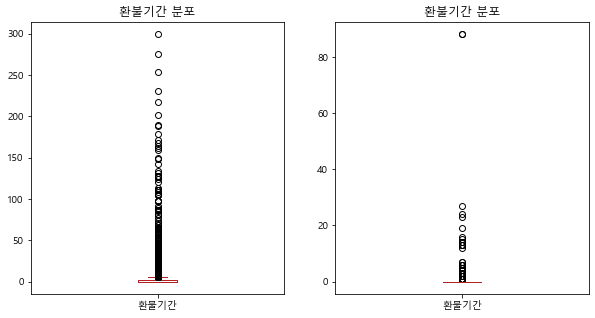

In [8]:
# 환불까지 7일 이상 걸리는 데이터가 백화점에서 많이 발생하며 환불상품군도 음료, 의류잡화이기에 sampling 오류라고 본다.
fig, ax = plt.subplots(1, 2, figsize=(10,5))
trans.query('구매매장ID=="백화점"')['환불기간'].plot.box(title="환불기간 분포", color='firebrick',ax=ax[0])
trans.query('구매매장ID=="하이마트"')['환불기간'].plot.box(title="환불기간 분포", color='firebrick',ax=ax[1])
plt.show()

In [9]:
# [DC] 환불기간이 7일을 넘는 데이터는 제거한다.
print('7일 이후 환불 건수:', trans.query('환불기간 > 7').shape[0])

purchase.drop(trans.query('환불기간 > 7').구매index.tolist() + trans.query('환불기간 > 7').환불index.tolist(), inplace=True)
print('구매데이터 크기:', purchase.shape[0])

7일 이후 환불 건수: 559
구매데이터 크기: 100207


In [10]:
# 환불, 구매 정보를 담고 있는 테이블에도 수정을 반영한다.
trans = trans.drop(trans.query('환불기간 > 7').index)
print('환불정보 데이터 크기:', trans.shape[0])
display(trans.isna().sum())

환불정보 데이터 크기: 7786


환불index       0
구매index    2015
환불기간       2015
환불매장ID        0
구매매장ID     2015
dtype: int64

In [11]:
# [DC] 원본데이터에도 매장ID 변경을 반영한다.
print('-------변경 전 매장별 거래건수-------')
display(purchase.매장ID.value_counts())

ease = trans[['환불index','환불매장ID']].values.tolist() + trans[['구매index','구매매장ID']].dropna().values.tolist()
ease += purchase.loc[set(purchase.index) - set(list(zip(*ease))[0]),'매장ID'].reset_index().values.tolist()
purchase['매장ID'] = pd.DataFrame(ease).sort_values(by=0)[1].values
print('-------변경 후 매장별 거래건수-------')
display(purchase.매장ID.value_counts())
display(purchase.isna().sum())

-------변경 전 매장별 거래건수-------


백화점     87778
하이마트    12429
Name: 매장ID, dtype: int64

-------변경 후 매장별 거래건수-------


백화점     87857
하이마트    12350
Name: 매장ID, dtype: int64

ID        0
상품대분류명    0
상품중분류명    0
구매지역      0
구매일자      0
구매수량      0
구매금액      0
취소여부      0
증정상품      0
거래ID      0
매장ID      0
dtype: int64

In [12]:
# [DC] 구매거래ID, 환불기간을 추가한다.
ease = trans.dropna()[['환불index','구매index','환불기간']]
ease['구매거래ID'] = purchase.loc[ease.구매index,'거래ID'].values
purchase = purchase.reset_index().merge(ease[['환불index','환불기간','구매거래ID']], left_on='index', right_on='환불index', how='left')
purchase.index = purchase['index'].values
purchase.drop(['index','환불index'], axis=1, inplace=True)

# 환불건수 7786개 중 누락데이터인 2015개 외의 데이터 정보를 추가했다.
display(purchase.notna().sum())

ID        100207
상품대분류명    100207
상품중분류명    100207
구매지역      100207
구매일자      100207
구매수량      100207
구매금액      100207
취소여부      100207
증정상품      100207
거래ID      100207
매장ID      100207
환불기간        5771
구매거래ID      5771
dtype: int64

`질문` 2014개의 구매데이터 누락 데이터는 2013년 말에 구매한 상품을 2014년에 환불한 경우일까?
- 해당 건수를 알아본 결과 예상대로 1월에 구매데이터가 누락된 환불건수가 많았다.
- 1월 외에도 구매 데이터가 누락된 건수는 `1814건`, 금액은 `3억 7천만원` 정도이다.
- 전부 제거하면 매출이 상승할 것이며 환불을 감안한 것까지가 월별 성과이다.<br>
  반대로 제거하지 않을 경우 자연적으론 발생할 수 없는 환불만 한 고객이 생겨난다.
- 현 데이터론 실제론 환불된 데이터도 가려낼 수 없기에 극히 일부인 누락데이터를 모두 `제거`한다.

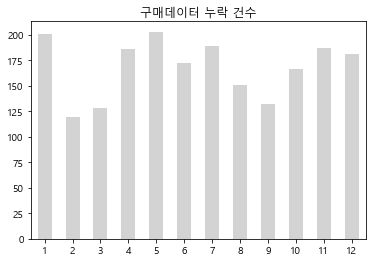

In [13]:
ease = purchase[purchase['환불기간'].isna() & purchase['취소여부']==1]
ease['구매일자'].dt.month.value_counts().sort_index().plot.bar(title="구매데이터 누락 건수", rot=0, color='lightgray')
plt.show()

In [14]:
print('1월 외 누락데이터 건수:', ease.query('구매일자 >= "2014-02-01"').shape[0])
print('1월 외 누락데이터 금액:', ease.query('구매일자 >= "2014-02-01"')['구매금액'].sum()*-1)

1월 외 누락데이터 건수: 1814
1월 외 누락데이터 금액: 375722000


In [15]:
print('1월 외 누락데이터 상대도수:', ease.query('구매일자 >= "2014-02-01"').shape[0]/purchase.shape[0])
print('1월 외 누락데이터 금액비율:', ease.query('구매일자 >= "2014-02-01"')['구매금액'].sum()*-1/purchase.구매금액.sum())

1월 외 누락데이터 상대도수: 0.01810252776752123
1월 외 누락데이터 금액비율: 0.04858738227107948


## Save data

In [16]:
purchase.to_csv('../data/DC_구매내역정보.csv', index=False, encoding='cp949')